# Config

In [22]:
import numpy as np
import matplotlib.pyplot as plt

M = 4
NL = 10000
SEED=42
np.random.seed(SEED)

# Utility

In [118]:
def h(l, T=1):
    return M**(-l)*T
   
def optimal_N(V, err=1e-4):
    temp = 0
    for i in range(len(V)):
        temp += np.sqrt(V[i]/h(i))
        
    return [int(2*err**(-2)*np.sqrt(V[i]*h(i))*temp) for i in range(len(V))]

# MLMC

In [120]:
def mlmc(sim_method, L=5, err=1e-4):
    V = []
    V2 = [0]
    N = []
    P = []
    Pa = []
    Y = [0]
    l = 0
    converge = False
    
    W = [np.sqrt(M**(-4)) * np.random.randn(NL) for _ in range(int(M**4))]

    W_l_dict = {L-1: W}

    for l in range(L-2, -1, -1):
        dt_l = h(l)
        n_steps_l = int(T / dt_l)
        W_l_dict[l] = [sum(W_l_dict[l+1][i*M : (i+1)*M]) for i in range(n_steps_l)]

    while (l < 2 or not converge) and l<L:
    #while l < L:
        pl, vl, parray = sim_method(W_l_dict[l], dt=h(l))
        #pl, vl, parray = sim_method(dt=h(l))
        P.append(pl)
        V.append(vl)
        Pa.append(parray)
        
        N = optimal_N(V, err)
        Nl = N[-1]
        
        if l >= 1:
            Yl = np.mean(Pa[l][:Nl]-Pa[l-1][:Nl])
            v2 = np.var(Pa[l][:Nl]-Pa[l-1][:Nl])
            Y.append(Yl)
            V2.append(v2)
            if l >= 2:
                converge = (max(Y[l-1]/M, Y[l]) < err*(M-1)/np.sqrt(2))
        
        l += 1
    
    return V, V2, P, Y, N

# 1. GBM

$dS = rSdt + \sigma SdW, 0<t<1$

## 1.1 European Option

$P = exp(-r)max(0, S(1)-1)$

In [89]:
def sim_euro(dW, n_paths=NL, dt=h(0), S0=1, r=0.05, sigma=0.2, T=1, K=1):
    S = np.full((n_paths,), S0, dtype=np.float64)
    
    n_steps = int(T/dt)
    for i in range(n_steps):
        #dW = np.sqrt(dt) * np.random.randn(n_paths)
        S += r * S * dt + sigma * S * dW[i]
    
    payoffs = np.exp(-r * T) * np.maximum(0, S - K)
    
    price = np.mean(payoffs)
    variance = np.var(payoffs, ddof=1)

    return price, variance, payoffs

In [90]:
V, V2, P, Y, N = mlmc(sim_euro)

C:\Users\Nvve\AppData\Local\Temp\ipykernel_20272\1745132279.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(V2) / np.log(4), label='log4(V2)', marker='s')


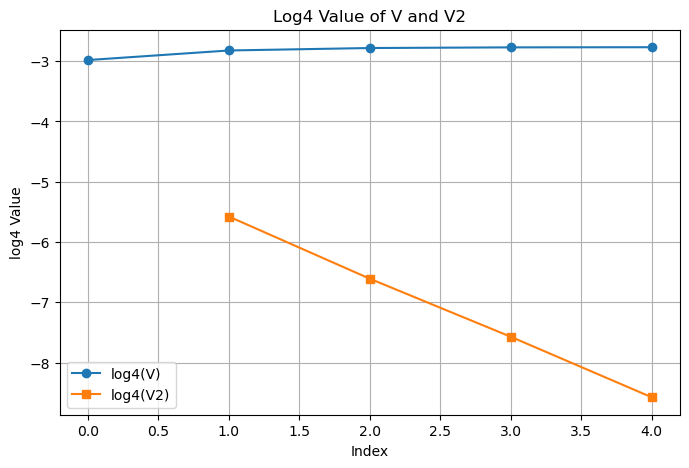

In [91]:
plt.figure(figsize=(8, 5))
plt.plot(np.log(V) / np.log(4), label='log4(V)', marker='o')
plt.plot(np.log(V2) / np.log(4), label='log4(V2)', marker='s')


plt.xlabel("Index")
plt.ylabel("log4 Value")
plt.title("Log4 Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

C:\Users\Nvve\AppData\Local\Temp\ipykernel_20272\665671232.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(P2) / np.log(4), label='log4(V2)', marker='s')
C:\Users\Nvve\AppData\Local\Temp\ipykernel_20272\665671232.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Y2) / np.log(4), label='log4(Y2)', marker='s')


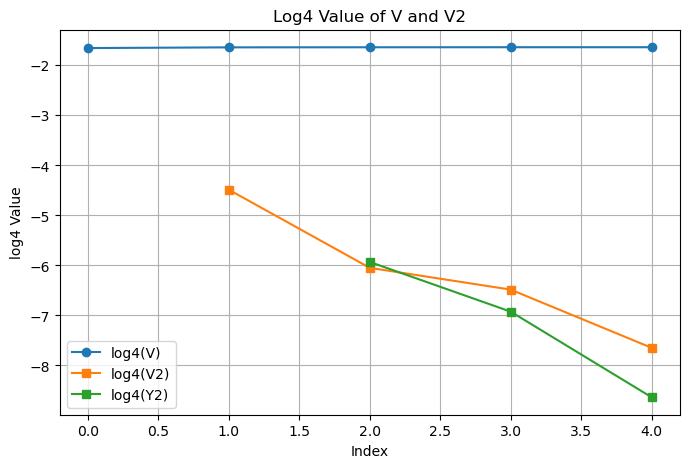

In [96]:
P2 = [0]+[P[i]-P[i-1] for i in range(1, 5)]
Y2 = [0, 0] + [abs(Y[i]-Y[i-1]/4) for i in range(2, 5)]

plt.figure(figsize=(8, 5))
plt.plot(np.log(P) / np.log(4), label='log4(V)', marker='o')
plt.plot(np.log(P2) / np.log(4), label='log4(V2)', marker='s')
plt.plot(np.log(Y2) / np.log(4), label='log4(Y2)', marker='s')

plt.xlabel("Index")
plt.ylabel("log4 Value")
plt.title("Log4 Value of V and V2")
plt.legend()
plt.grid(True)


plt.show()

In [122]:
Nlist = []
for err in [0.001, 0.0005, 0.0001, 0.0002, 0.00005]:
    _, _, _, _, Nx = mlmc(sim_euro, err=err)
    Nlist.append(Nx)

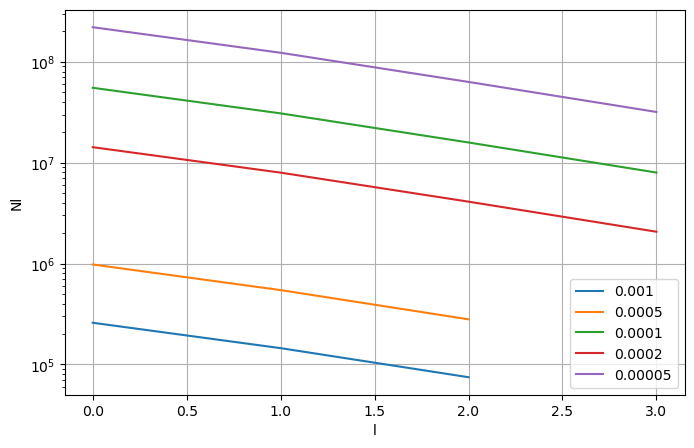

In [123]:
plt.figure(figsize=(8, 5))
plt.plot(Nlist[0], label='0.001')
plt.plot(Nlist[1], label='0.0005')
plt.plot(Nlist[2], label='0.0001')
plt.plot(Nlist[3], label='0.0002')
plt.plot(Nlist[4], label='0.00005')

plt.xlabel("l")
plt.ylabel("Nl")
plt.yscale('log')
plt.legend()
plt.grid(True)


plt.show()

In [127]:
costs = []
for i in range(5):
    cost = 0
    for j in range(len(Nlist[i])):
        cost += Nlist[i][j]*h(j)
    costs.append(cost)

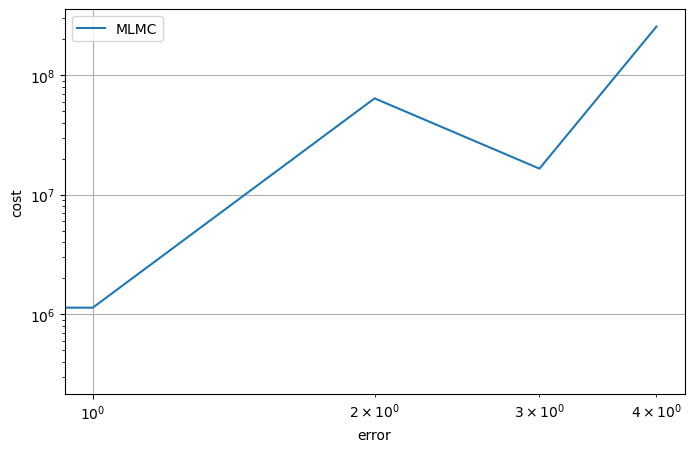

In [128]:
plt.figure(figsize=(8, 5))
plt.plot(costs, label='MLMC')

plt.xlabel("error")
plt.xscale('log')
plt.ylabel("cost")
plt.yscale('log')
plt.legend()
plt.grid(True)


plt.show()